In [1]:
# import the necessary packages
import face_recognition
import imutils
import pickle
import time
import cv2
from IPython.display import clear_output
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np

In [2]:
#Use 'jpeg' instead of 'png' (~5 times faster)
def array_to_image(a, fmt='jpeg'):
    #Create binary stream object
    f = BytesIO()
    #Convert array to binary stream object
    PIL.Image.fromarray(a).save(f, fmt)
    return IPython.display.Image(data=f.getvalue())

In [3]:
data = pickle.loads(open("/home/pi/Desktop/me34Notebook/opencv/faceDetection/encodings.pickle", "rb").read())
detector = cv2.CascadeClassifier("/home/pi/Desktop/me34Notebook/opencv/faceDetection/haarcascade_frontalface_default.xml")

In [4]:
def get_frame(cam):
    # Capture frame-by-frame
    ret, frame = cam.read()
    #flip image for natural viewing
    #frame = cv2.flip(frame, 1)
    return frame

In [5]:
cam = cv2.VideoCapture(0)

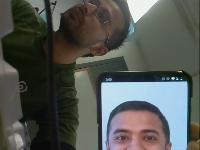

In [6]:
d = IPython.display.display("", display_id=1)
#d2 = IPython.display.display("", display_id=2)

In [7]:
#Press 'i' two times to interrupt the Kernel 
#Run the code in the cell below (cam.release) to make sure the Camera is free
while True:
	t1 = time.time()

	# grab the frame from the threaded video stream and resize it
	# to 300px (to speedup processing)
	frame = get_frame(cam)
	frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
	# For Pi Zero use inter=cv2.INTER_LINEAR    
	frame = imutils.resize(frame, width=200, inter=cv2.INTER_LINEAR)

	# convert the input frame from (1) BGR to grayscale (for face
	# detection) and (2) from BGR to RGB (for face recognition)
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

	# detect faces in the grayscale frame
	rects = detector.detectMultiScale(gray, scaleFactor=1.1, 
		minNeighbors=5, minSize=(30, 30),
		flags=cv2.CASCADE_SCALE_IMAGE)

	# OpenCV returns bounding box coordinates in (x, y, w, h) order
	# but we need them in (top, right, bottom, left) order, so we
	# need to do a bit of reordering
	boxes = [(y, x + w, y + h, x) for (x, y, w, h) in rects]

	# compute the facial embeddings for each face bounding box
	encodings = face_recognition.face_encodings(frame, boxes)
	names = []

	# loop over the facial embeddings
	for encoding in encodings:
		# attempt to match each face in the input image to our known
		# encodings
		matches = face_recognition.compare_faces(data["encodings"],
			encoding)
		name = "Unknown"

		# check to see if we have found a match
		if True in matches:
			# find the indexes of all matched faces then initialize a
			# dictionary to count the total number of times each face
			# was matched
			matchedIdxs = [i for (i, b) in enumerate(matches) if b]
			counts = {}

			# loop over the matched indexes and maintain a count for
			# each recognized face face
			for i in matchedIdxs:
				name = data["names"][i]
				counts[name] = counts.get(name, 0) + 1

			# determine the recognized face with the largest number
			# of votes (note: in the event of an unlikely tie Python
			# will select first entry in the dictionary)
			name = max(counts, key=counts.get)
		
		# update the list of names
		names.append(name)

	# loop over the recognized faces
	for ((top, right, bottom, left), name) in zip(boxes, names):
		# draw the predicted face name on the image
		cv2.rectangle(frame, (left, top), (right, bottom),
			(0, 255, 0), 2)
		y = top - 15 if top - 15 > 15 else top + 15
		cv2.putText(frame, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
			0.75, (0, 255, 0), 2)

	im = array_to_image(frame)
	d.update(im)
	#t2 = time.time()
	#s = f"""{int(1/(t2-t1))} FPS"""
	#d2.update( IPython.display.HTML(s) )
	if cv2.waitKey(1) & 0xFF == ord("q"):
		break


KeyboardInterrupt: 

In [8]:
cam.release()
IPython.display.clear_output()
print ("Stream stopped")
cv2.destroyAllWindows()


Stream stopped
